# Fine Tune NER Model

To fine-tune a Named Entity Recognition (NER) model to extract key entities (products, prices, and location) from Amharic Telegram messages, we will follow these steps.

 **Step 1:** Set Up Environment with GPU Support
 - Use Google Colab or GPU-Enabled Environment Ensure that selected a runtime with GPU in Google Colab:
   - Go to Runtime > Change runtime type > Select GPU.
 - Install Necessary Libraries
   - Run the following commands in a code cell to install the required libraries: send markdown

## Step 1:  Import Libraries

In [1]:
!pip install pyarrow datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=19392f4b1cc7d471a8b4bbce9abfac4b1cbfda08339b8731eed696a7e0147647
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import XLMRobertaTokenizerFast
from datasets import Dataset, Features, Sequence, Value
from transformers import TrainingArguments
from transformers import XLMRobertaForTokenClassification, AutoModelForTokenClassification, AutoTokenizer, Trainer


## **Step 2:** Load the Labeled Dataset from CoNLL File
- Load the CoNLL Dataset
  - we can load our CoNLL formatted data into a DataFrame. Here's how we can do that:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Function to load CoNLL formatted data into a Pandas DataFrame
def load_conll_to_dataframe(file_path):
    """
    Loads data from a CoNLL formatted file into a pandas DataFrame.

    Args:
        file_path (str): The path to the CoNLL file.

    Returns:
        pd.DataFrame: A DataFrame with 'tokens' and 'labels' columns.
    """
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        sentence_tokens = []
        sentence_labels = []
        for line in f:
            line = line.strip()
            if line:  # Non-empty line contains a token and its label
                token, label_item = line.split()
                sentence_tokens.append(token)
                sentence_labels.append(label_item)
            else:  # Empty line indicates the end of a sentence
                # Append the completed sentence and its labels
                sentences.append(sentence_tokens)
                labels.append(sentence_labels)
                # Reset lists for the next sentence
                sentence_tokens = []
                sentence_labels = []
        # Append the last sentence if the file does not end with an empty line
        if sentence_tokens:
            sentences.append(sentence_tokens)
            labels.append(sentence_labels)

    # Create a DataFrame from the extracted sentences and labels
    return pd.DataFrame({'tokens': sentences, 'labels': labels})

# Load the CoNLL dataset from the specified file path
df = load_conll_to_dataframe('/content/drive/MyDrive/kaim 6/week4/labeled_data_from_df.conll')

In [5]:
# Explore the first few rows
df.head()

,tokens,labels
0,"[saachi, electric, kettle, borosilicate, glass...","[O, O, O, O, O, O, O, O, O, O, O, O, B-PRICE, ..."
1,"[3pcs, bottle, stopper, በማንኛውም, ጠርሙስ, ጫፍ, የሚገጠ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[3pcs, bottle, stopper, በማንኛውም, ጠርሙስ, ጫፍ, የሚገጠ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[1, pairs, sneaker, crease, protector, ዋጋ, 400...","[B-PRICE, O, O, O, O, B-PRICE, I-PRICE, I-PRIC..."
4,"[1, pairs, sneaker, crease, protector, ዋጋ, 400...","[B-PRICE, O, O, O, O, B-PRICE, I-PRICE, I-PRIC..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11457 entries, 0 to 11456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  11457 non-null  object
 1   labels  11457 non-null  object
dtypes: object(2)
memory usage: 179.1+ KB


### Define Unique Labels

In [7]:
# Get all unique labels from the 'labels' column
all_labels = [label for sublist in df['labels'] for label in sublist]
# Create a set of unique labels to ensure no duplicates
unique_labels = sorted(list(set(all_labels)))

# Create a dictionary mapping each unique label to a unique integer ID
label2id = {label: i for i, label in enumerate(unique_labels)}

# Create a dictionary mapping each integer ID back to its corresponding label
id2label = {i: label for label, i in label2id.items()}

# Print the mappings and the number of unique labels
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)
print("Number of unique labels:", len(unique_labels))

Label to ID mapping: {'B-LOC': 0, 'B-PHONE': 1, 'B-PRICE': 2, 'B-PRODUCT': 3, 'I-LOC': 4, 'I-PHONE': 5, 'I-PRICE': 6, 'I-PRODUCT': 7, 'O': 8}
ID to Label mapping: {0: 'B-LOC', 1: 'B-PHONE', 2: 'B-PRICE', 3: 'B-PRODUCT', 4: 'I-LOC', 5: 'I-PHONE', 6: 'I-PRICE', 7: 'I-PRODUCT', 8: 'O'}
Number of unique labels: 9


In [8]:
unique_labels

['B-LOC',
 'B-PHONE',
 'B-PRICE',
 'B-PRODUCT',
 'I-LOC',
 'I-PHONE',
 'I-PRICE',
 'I-PRODUCT',
 'O']

In [9]:
df['labels'] = df['labels'].apply(lambda x: [label2id[label] for label in x])


## **Step 3:** Convert DataFrame to Hugging Face Dataset

In [10]:
# Define the features for the dataset, including tokens and labels
features = Features({
    'tokens': Sequence(Value('string')),  # Sequence of strings for tokens
    'labels': Sequence(Value('int64'))    # Sequence of integers for labels (corresponding to label IDs)
})

# Convert DataFrame to Hugging Face Dataset with specified features
dataset = Dataset.from_pandas(df[['tokens', 'labels']], features=features)

# Print the dataset to verify the conversion
print(dataset)

Dataset({
    features: ['tokens', 'labels'],
    num_rows: 11457
})


## Step 4: Tokenization and Label Alignment

- Maintain Consistent Tokenization Across Models: When evaluating multiple models, it's important to ensure that each model uses a tokenization method suited to its specific architecture.

- Tokenizers such as those used by XLM-Roberta, DistilBERT, and mBERT differ, so tokenization must be adjusted accordingly for each model.



### Tokenize and align label for XLM-ROBERTA

In [11]:
# Use the fast tokenizer
# For XLM-Roberta
tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    "xlm-roberta-base",
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs
# Tokenize the dataset using xlrm_berta
tokenized_xlm_dataset = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Map:   0%|          | 0/11457 [00:00<?, ? examples/s]

### Tokenize and align for mbert

In [14]:
# For mBERT
tokenizer_mbert = AutoTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels_mbert(examples):
    tokenized_inputs = tokenizer_mbert(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs
# Tokenize the dataset using mberta
tokenized_mbert_dataset = dataset.map(tokenize_and_align_labels_mbert, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/11457 [00:00<?, ? examples/s]

### Tokenize and align label for DistilBERT


In [12]:
# For DistilBERT
tokenizer_distilbert = AutoTokenizer.from_pretrained(
    'distilbert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels_distilbert(examples):
    tokenized_inputs = tokenizer_distilbert(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs
tokenized_distilbert_dataset = dataset.map(tokenize_and_align_labels_distilbert, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/11457 [00:00<?, ? examples/s]

### Split the dataset into train and test data of each tokenized dataset

In [15]:
# Split into train and validation datasets
train_test_split_xlm = tokenized_xlm_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_mbert = tokenized_mbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_distilbert = tokenized_distilbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation


## **Step 5:** Set Up Training Arguments

- Configure common training arguments for all models.

In [16]:
# Set up training arguments with adjustments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",     # Evaluates at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # Strength of weight decay
    max_grad_norm=1.0,  # Gradient clipping
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="steps",        # Log at regular intervals
    logging_steps=50,                # Log every 50 steps
    save_strategy="epoch",           # Save model at the end of each epoch
    report_to="none",                # Only show logs in the output (no TensorBoard)
    # Use GPU for training
    load_best_model_at_end=True,     # Load the best model (based on metric) at the end
    metric_for_best_model="eval_loss",# Metric used to determine the best model
    save_total_limit=1,              # Only keep the best model, delete the others
)

### **Step 6:** Load and Fine-Tune the pre-trained model

- Use Hugging Face Trainer API

Fine-tune the model using the Trainer API.

- fine-tune each of the following pre-trained models:

- `xlm-roberta-base`

- `DistilBERT`

- `mBERT`

In [17]:
# Initialize each of the models
# For XLM-Roberta
model_xlmr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(unique_labels)) # Ensure unique_labels is defined
# For DistilBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(unique_labels))
# For mBERT
model_mbert = AutoModelForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(unique_labels))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Set Up Trainer for Each Model

Create a custom compute_metrics function using scikit-learn to calculate precision, recall, and F1-score, and provide it to each model’s Trainer.

In [18]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

# Define the function to compute evaluation metrics using seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Convert label IDs back to labels for seqeval
    true_labels = [[id2label[label] for label in label_row if label != -100] for label_row in labels]
    predicted_labels = [[id2label[pred] for pred, true in zip(pred_row, true_row) if true != -100] for pred_row, true_row in zip(predictions, labels)]

    # Use seqeval metrics
    results = {
        "precision": precision_score(true_labels, predicted_labels),
        "recall": recall_score(true_labels, predicted_labels),
        "f1": f1_score(true_labels, predicted_labels)
    }
    return results



In [19]:
trainer_xlmr = Trainer(
    model=model_xlmr,
    args=training_args,
    train_dataset=train_test_split_xlm['train'],
    eval_dataset=train_test_split_xlm['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)

In [20]:
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_mbert['train'],
    eval_dataset=train_test_split_mbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)


In [21]:
trainer_mbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_distilbert['train'],
    eval_dataset=train_test_split_distilbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)

### **Step 8:** Model Training, Evaluation, and Comparison:

* Once all three models have been trained, assess their performance using evaluation metrics like F1-score, Precision, Recall, and Accuracy.
* Perform training individually for each model.


In [22]:
# Store results of each model
results = {}

# Fine-tune XLM-Roberta
print('For XLM-Roberta')
results['xlmr'] = trainer_xlmr.train()

# Fine-tune DistilBERT
print('For DistilBERT')
results['distilbert'] = trainer_distilbert.train()

# Fine-tune mBERT
print('For mBERT')
results['mbert'] = trainer_mbert.train()

# To get evaluation results after training, you can use trainer.evaluate()
eval_results_xlmr = trainer_xlmr.evaluate()
eval_results_distilbert = trainer_distilbert.evaluate()
eval_results_mbert = trainer_mbert.evaluate()

print("\nXLM-Roberta Evaluation Results:", eval_results_xlmr)
print("DistilBERT Evaluation Results:", eval_results_distilbert)
print("mBERT Evaluation Results:", eval_results_mbert)

For XLM-Roberta


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.002900,0.002833,0.995106,0.998182,0.996642
2,0.002100,0.001358,0.997640,0.999091,0.998365
3,0.001100,0.001125,0.998184,0.999455,0.998819


For DistilBERT


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.082400,0.079479,0.960484,0.861928,0.908541
2,0.057800,0.054952,0.953181,0.924702,0.938725
3,0.051800,0.045314,0.971851,0.932549,0.951794


For mBERT


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.041600,0.037899,0.964058,0.939642,0.951693
2,0.036300,0.028982,0.973085,0.959509,0.966249
3,0.029200,0.025556,0.981150,0.962997,0.971988



XLM-Roberta Evaluation Results: {'eval_loss': 0.0011254084529355168, 'eval_precision': 0.9981841292899946, 'eval_recall': 0.9994545454545455, 'eval_f1': 0.9988189334060144, 'eval_runtime': 8.508, 'eval_samples_per_second': 134.697, 'eval_steps_per_second': 8.463, 'epoch': 3.0}
DistilBERT Evaluation Results: {'eval_loss': 0.02417793497443199, 'eval_precision': 0.9818656831104964, 'eval_recall': 0.9640863135657161, 'eval_f1': 0.9728947769148775, 'eval_runtime': 4.5425, 'eval_samples_per_second': 252.285, 'eval_steps_per_second': 15.85, 'epoch': 3.0}
mBERT Evaluation Results: {'eval_loss': 0.02555558830499649, 'eval_precision': 0.9811495673671199, 'eval_recall': 0.9629966636336063, 'eval_f1': 0.9719883667534057, 'eval_runtime': 4.6182, 'eval_samples_per_second': 248.147, 'eval_steps_per_second': 15.59, 'epoch': 3.0}



- Utilize the Trainer’s `evaluate()` method to obtain evaluation metrics for each model, then compare the results side by side to identify which model performs best for the NER task.


### Visualize the evaluation result to better understand

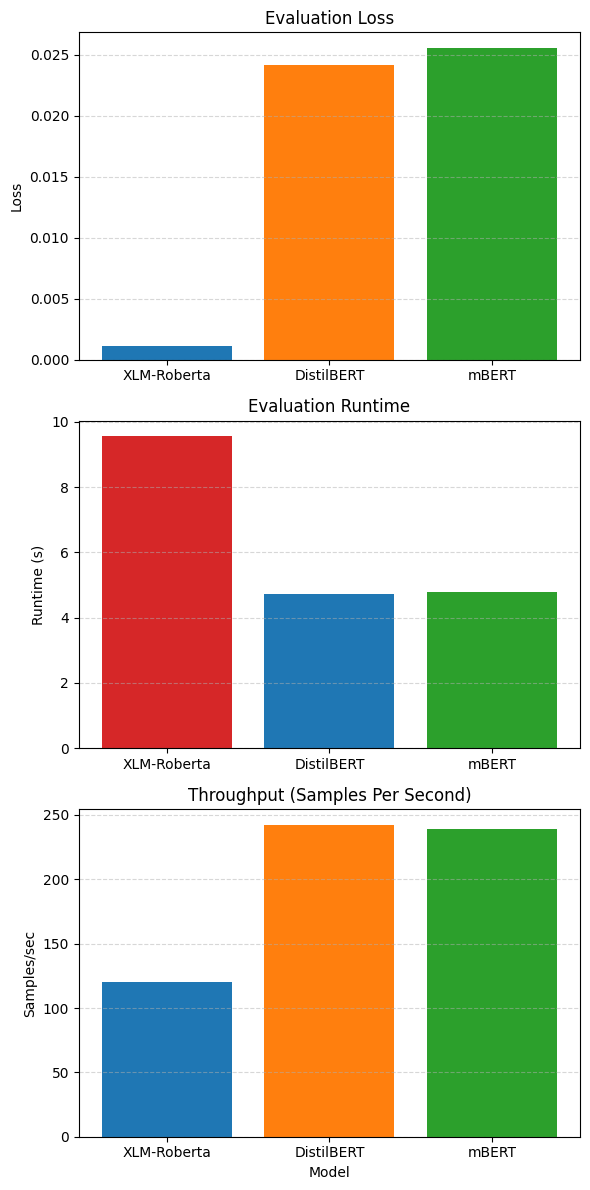

In [31]:
# Step 1: Evaluate models and collect results
model_results = {
    'XLM-Roberta': trainer_xlmr.evaluate(),
    'DistilBERT': trainer_distilbert.evaluate(),
    'mBERT': trainer_mbert.evaluate()
}

# Step 2: Extract key evaluation metrics
eval_loss = [model_results[model]['eval_loss'] for model in model_results]
eval_runtime = [model_results[model]['eval_runtime'] for model in model_results]
samples_per_second = [model_results[model]['eval_samples_per_second'] for model in model_results]
model_names = list(model_results.keys())

# Step 3: Visualization (stacked vertically)
plt.figure(figsize=(6, 12))

# Evaluation Loss Plot
plt.subplot(3, 1, 1)
plt.bar(model_names, eval_loss, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Evaluation Loss')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Evaluation Runtime Plot
plt.subplot(3, 1, 2)
plt.bar(model_names, eval_runtime, color=['#d62728', '#1f77b4', '#2ca02c'])
plt.title('Evaluation Runtime')
plt.ylabel('Runtime (s)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Samples Per Second Plot
plt.subplot(3, 1, 3)
plt.bar(model_names, samples_per_second, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Throughput (Samples Per Second)')
plt.ylabel('Samples/sec')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Visualize the result

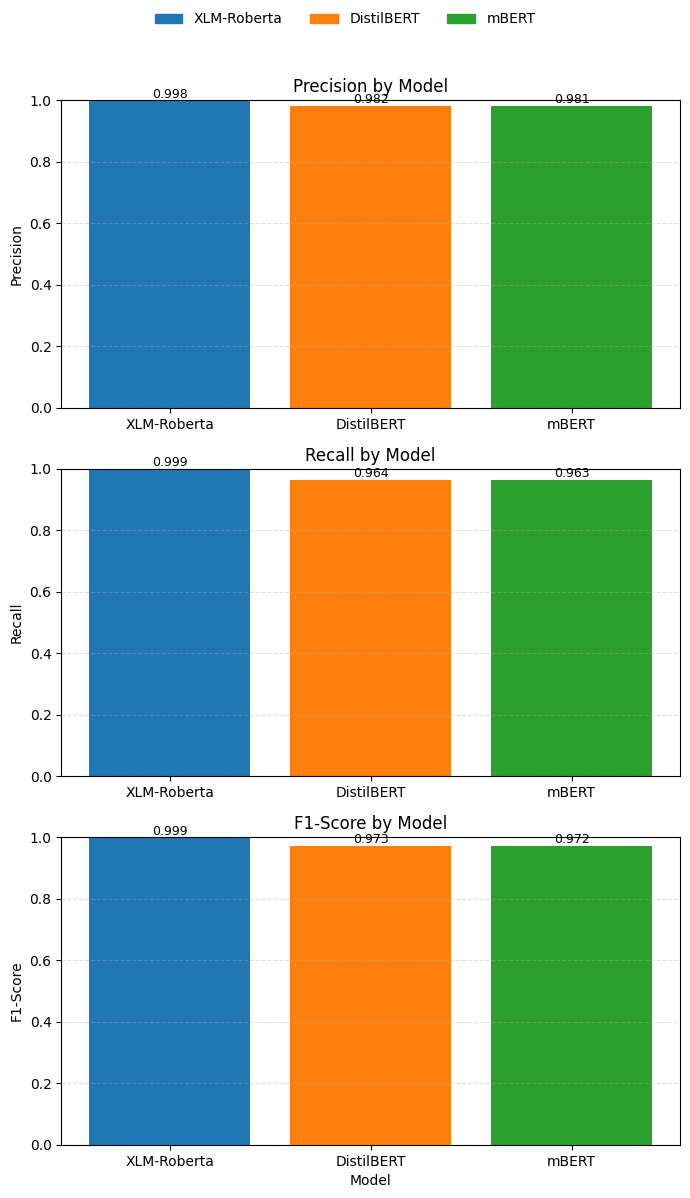

In [33]:
# Step 1: Extract metric values
model_names = list(results.keys())
precision = [results[m]['eval_precision'] for m in model_names]
recall = [results[m]['eval_recall'] for m in model_names]
f1 = [results[m]['eval_f1'] for m in model_names]

# Step 2: Assign distinct colors for each model
colors = {
    'XLM-Roberta': '#1f77b4',   # Blue
    'DistilBERT': '#ff7f0e',    # Orange
    'mBERT': '#2ca02c'          # Green
}
bar_colors = [colors[m] for m in model_names]

# Step 3: Plot vertically
plt.figure(figsize=(7, 12))

# Precision Plot
plt.subplot(3, 1, 1)
bars = plt.bar(model_names, precision, color=bar_colors)
plt.title('Precision by Model')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', fontsize=9)

# Recall Plot
plt.subplot(3, 1, 2)
bars = plt.bar(model_names, recall, color=bar_colors)
plt.title('Recall by Model')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', fontsize=9)

# F1-Score Plot
plt.subplot(3, 1, 3)
bars = plt.bar(model_names, f1, color=bar_colors)
plt.title('F1-Score by Model')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', fontsize=9)

# Add a legend for color meaning
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[m]) for m in model_names]
plt.figlegend(handles, model_names, loc='upper center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


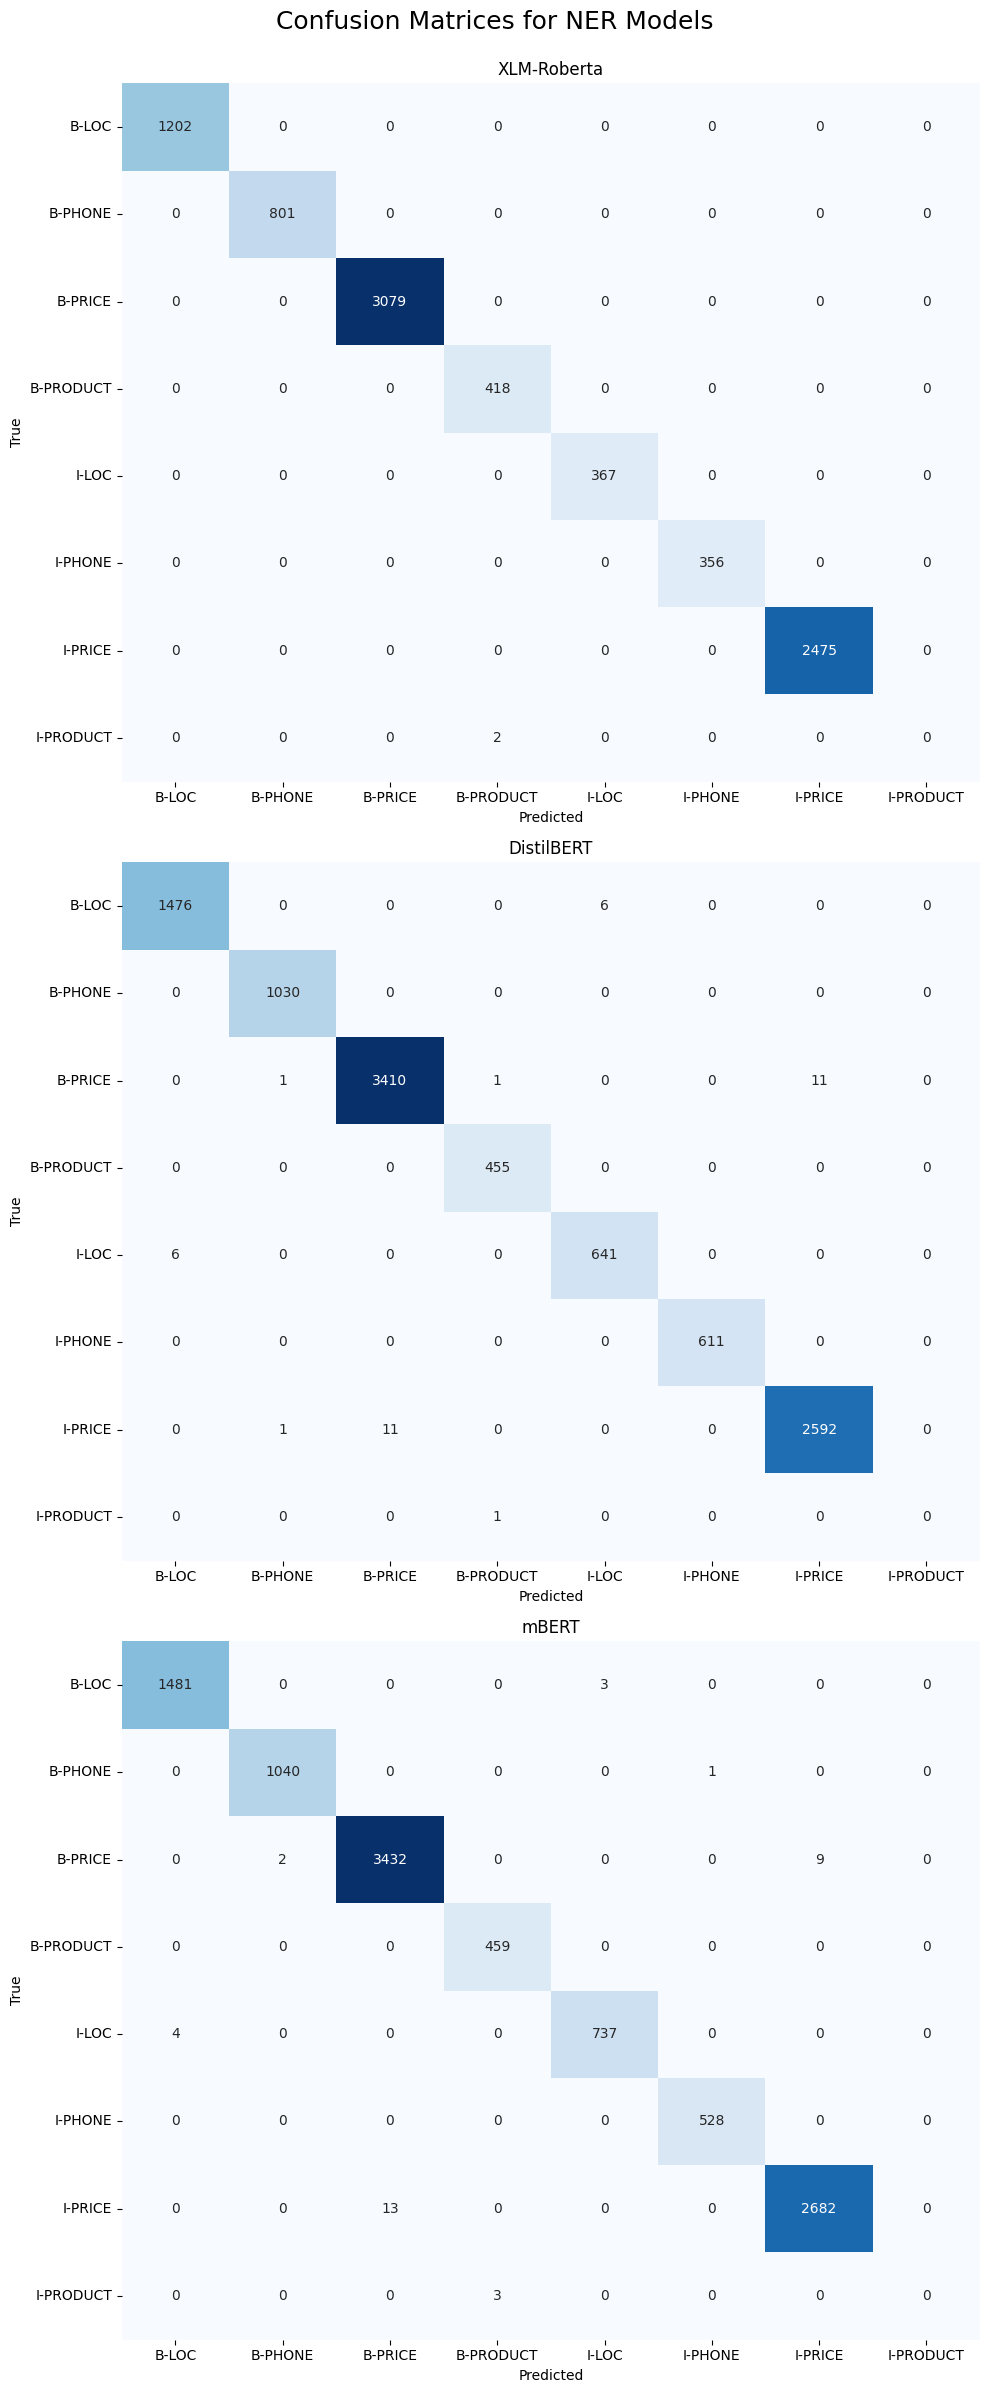


📊 XLM-Roberta Classification Report:
              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00      1202
       PHONE       1.00      1.00      1.00       801
       PRICE       1.00      1.00      1.00      3079
     PRODUCT       0.98      1.00      0.99       418

   micro avg       1.00      1.00      1.00      5500
   macro avg       0.99      1.00      1.00      5500
weighted avg       1.00      1.00      1.00      5500


📊 DistilBERT Classification Report:
              precision    recall  f1-score   support

         LOC       0.95      0.95      0.95      1545
       PHONE       1.00      1.00      1.00      1030
       PRICE       0.99      0.98      0.98      3482
     PRODUCT       0.99      0.85      0.91       537

   micro avg       0.98      0.96      0.97      6594
   macro avg       0.98      0.94      0.96      6594
weighted avg       0.98      0.96      0.97      6594


📊 mBERT Classification Report:
              precision

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report
import itertools

def plot_confusion_matrix(true_labels, predicted_labels, labels, model_name, ax):
    """Plots a confusion matrix on the given axes."""
    # Flatten labels
    flat_true = list(itertools.chain(*true_labels))
    flat_pred = list(itertools.chain(*predicted_labels))

    cm = confusion_matrix(flat_true, flat_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', ax=ax, cbar=False)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


def get_true_and_predicted_labels(trainer, dataset, id2label):
    """Gets predicted and true labels from trainer output."""
    predictions, labels, _ = trainer.predict(dataset)
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    pred_labels = []

    for label_seq, pred_seq in zip(labels, predictions):
        true_seq = []
        pred_seq_clean = []
        for true_id, pred_id in zip(label_seq, pred_seq):
            if true_id != -100:
                true_seq.append(id2label[true_id])
                pred_seq_clean.append(id2label[pred_id])
        true_labels.append(true_seq)
        pred_labels.append(pred_seq_clean)

    return true_labels, pred_labels


# Get predictions for all models
true_labels_xlmr, pred_labels_xlmr = get_true_and_predicted_labels(trainer_xlmr, train_test_split_xlm['test'], id2label)
true_labels_distilbert, pred_labels_distilbert = get_true_and_predicted_labels(trainer_distilbert, train_test_split_distilbert['test'], id2label)
true_labels_mbert, pred_labels_mbert = get_true_and_predicted_labels(trainer_mbert, train_test_split_mbert['test'], id2label)

# Labels to show (excluding "O")
labels_to_display = sorted([lbl for lbl in id2label.values() if lbl != 'O'])

# Plot all confusion matrices vertically
fig, axes = plt.subplots(3, 1, figsize=(10, 24))  # Adjust height as needed
plot_confusion_matrix(true_labels_xlmr, pred_labels_xlmr, labels_to_display, 'XLM-Roberta', axes[0])
plot_confusion_matrix(true_labels_distilbert, pred_labels_distilbert, labels_to_display, 'DistilBERT', axes[1])
plot_confusion_matrix(true_labels_mbert, pred_labels_mbert, labels_to_display, 'mBERT', axes[2])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.suptitle("Confusion Matrices for NER Models", fontsize=18, y=0.995)
plt.show()

# Print detailed classification reports
print("\n📊 XLM-Roberta Classification Report:")
print(classification_report(true_labels_xlmr, pred_labels_xlmr))

print("\n📊 DistilBERT Classification Report:")
print(classification_report(true_labels_distilbert, pred_labels_distilbert))

print("\n📊 mBERT Classification Report:")
print(classification_report(true_labels_mbert, pred_labels_mbert))


## Saving the Best model to DRIVE

In [51]:
# Identify the best performing model based on f1-score from evaluation results
best_model_name = max(
    ['xlmr', 'distilbert', 'mbert'],
    key=lambda k: {
        'xlmr': eval_results_xlmr,
        'distilbert': eval_results_distilbert,
        'mbert': eval_results_mbert
    }[k]['eval_f1']
)
print(f"The best performing model is: {best_model_name}")

# Save the best model
save_directory = 'best_ner_model'

if best_model_name == 'xlmr':
    trainer_xlmr.save_model(save_directory)
    print(f"XLM-Roberta model saved to {save_directory}")
elif best_model_name == 'distilbert':
    trainer_distilbert.save_model(save_directory)
    print(f"DistilBERT model saved to {save_directory}")
elif best_model_name == 'mbert':
    trainer_mbert.save_model(save_directory)
    print(f"mBERT model saved to {save_directory}")
else:
    print("Could not identify the best model to save.")

The best performing model is: xlmr
XLM-Roberta model saved to best_ner_model


In [52]:
!pip install huggingface_hub

In [54]:
from huggingface_hub import notebook_login
from huggingface_hub import HfApi

# Log in to Hugging Face Hub
# This will open an interactive cell to input your Hugging Face token
notebook_login()

# Replace with your desired repository name on Hugging Face Hub
# It should be in the format 'your_username/your_model_name'
# Make sure to create an empty repository with this name on Hugging Face first
repo_name = "doffn/tenx_best_NLP_model" # REPLACE THIS WITH YOUR USERNAME AND DESIRED MODEL NAME

# Initialize HfApi
api = HfApi()

# Push the saved model directory to the Hugging Face Hub
try:
    # Push the entire saved directory
    api.upload_folder(
        folder_path=save_directory,
        repo_id=repo_name,
        repo_type="model",
    )
    print(f"Model successfully uploaded to https://huggingface.co/{repo_name}")


except Exception as e:
    print("there is an error{e}")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Model successfully uploaded to https://huggingface.co/doffn/tenx_best_NLP_model
